In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
import torchvision
import sys
import os

In [3]:
sys.path.append(os.path.abspath(os.path.join('..', 'Median')))
sys.path.append(os.path.abspath(os.path.join('..', 'BM3D')))
sys.path.append(os.path.abspath(os.path.join('..', 'OndelettesHaar')))
sys.path.append(os.path.abspath(os.path.join('..', '_CGNet_BSD500')))
from median_color import median_denoise_color
from bm3d_color import bm3d_denoise_color
from ondelettes_haar_color import wavelet_denoise_color
from CGNet_BSD500 import CGNetDenoising

In [4]:
# Utils

# Importer une image
def import_image(filename):
    image = ski.io.imread(filename)
    return np.array(image)

# Afficher une image
def display_image(image, title):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Bruiter une image
def noise_image(image, noise_type='gaussian'):
    match noise_type:
        case 'gaussian':
            image_noised = ski.util.random_noise(image, mode=noise_type, mean=0, var=0.01) * 255
        case 's&p':
            image_noised = ski.util.random_noise(image, mode=noise_type, amount=0.05) * 255
        case _:
            image_noised = image
    image_noised = image_noised.astype(np.uint8)
    return image_noised

In [53]:
def compare_denoising_methods(image, image_noised, model_path='../_CGNet_BSD500/cgnet_denoising_optimized.pth', median_func=None, wavelet_func=None, bm3d_func=None):
    display_image(image, "Image originale")
    display_image(image_noised, "Image bruitée")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cgnet_model = CGNetDenoising().to(device)
    cgnet_model.load_state_dict(torch.load(model_path))
    cgnet_model.eval()
    
    psnr_results = {}
    
    # CGNet
    noisy_tensor = torchvision.transforms.ToTensor()(image_noised).unsqueeze(0).to(device)
    with torch.no_grad():
        output_cgnet = cgnet_model(noisy_tensor).cpu().squeeze()
    
    # Redimensionnement si nécessaire
    if image.shape[:2] != output_cgnet.shape[1:]:
        print("Redimensionnement nécessaire")
        resize = transforms.Resize((image.shape[0], image.shape[1]))
        output_cgnet_resized = resize(output_cgnet.unsqueeze(0)).squeeze(0)
    else:
        output_cgnet_resized = output_cgnet
    
    # Réarranger l'ordre des canaux : de (C, H, W) à (H, W, C)
    output_cgnet_resized = output_cgnet_resized.permute(1, 2, 0)
    
    # Convertir en NumPy
    output_cgnet_resized = output_cgnet_resized.numpy()
    
    # Vérifier et ajuster la forme de l'image si nécessaire
    if len(output_cgnet_resized.shape) == 3 and output_cgnet_resized.shape[-1] == 1:
        output_cgnet_resized = output_cgnet_resized.squeeze(-1)
    
    # S'assurer que les valeurs sont dans l'intervalle [0, 255]
    output_cgnet_resized = np.clip(output_cgnet_resized * 255, 0, 255)
    
    # Convertir en uint8
    output_cgnet_resized = output_cgnet_resized.astype(np.uint8)
    
    # Sauvegarder l'image
    ski.io.imsave("cgnet_result.png", output_cgnet_resized)
    
    # Calculer le PSNR
    psnr_cgnet = psnr(image, output_cgnet_resized)
    psnr_results['CGNet'] = psnr_cgnet
    
    # Afficher l'image débruitée
    display_image(output_cgnet_resized, "Image débruitée par CGNet")

    # Filtre médian
    if median_func is not None:
        image_median = median_func(image_noised)
        psnr_median = psnr(image, image_median)
        psnr_results['Filtre médian'] = psnr_median
        display_image(image_median, "Image débruitée par le filtre médian")

    # Haar
    if wavelet_func is not None:
        image_wavelet = wavelet_func(image_noised)
        if image_wavelet.shape != image.shape:
            image_wavelet = ski.transform.resize(image_wavelet, image.shape, mode='reflect', anti_aliasing=True)
            image_wavelet = np.clip(image_wavelet, 0, 1) * 255
        image_wavelet = image_wavelet.astype(np.uint8)
        psnr_wavelet = psnr(image, image_wavelet)
        psnr_results['Ondelettes de Haar'] = psnr_wavelet
        display_image(image_wavelet, "Image débruitée par les ondelettes de Haar")

    # BM3D
    if bm3d_func is not None:
        image_bm3d = bm3d_func(image_noised, 0.1)
        psnr_bm3d = psnr(image, image_bm3d)
        psnr_results['BM3D'] = psnr_bm3d
        display_image(image_bm3d, "Image débruitée par BM3D")
    
    for method, psnr_value in psnr_results.items():
        print(f"PSNR pour {method}: {psnr_value:.2f}")

    return psnr_results

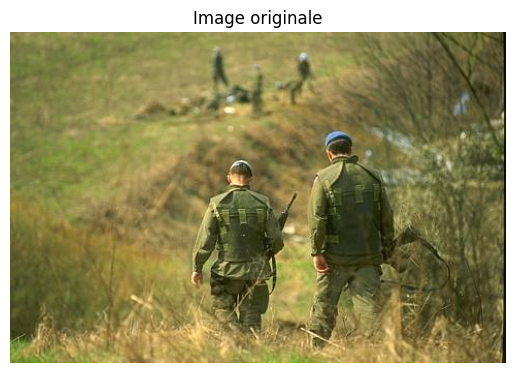

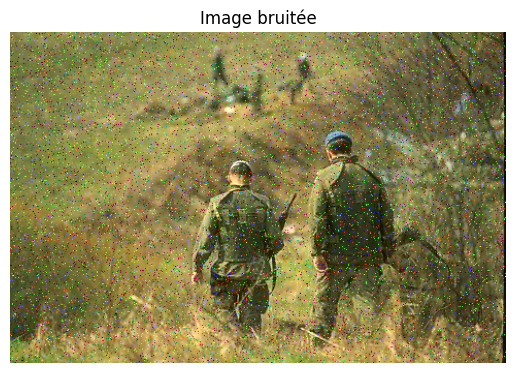

/tmp/ipykernel_7797/3133487343.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cgnet_model.load_state_dict(torch.load(model_path))


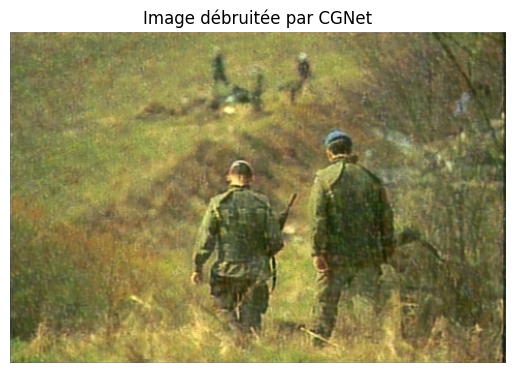

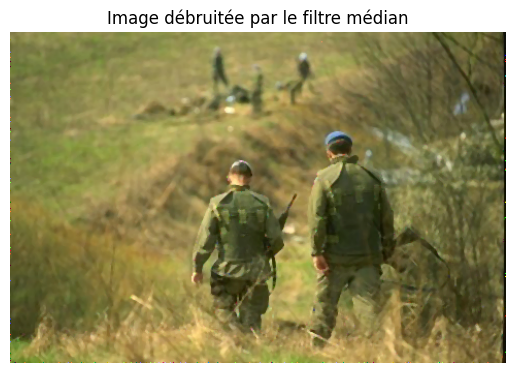

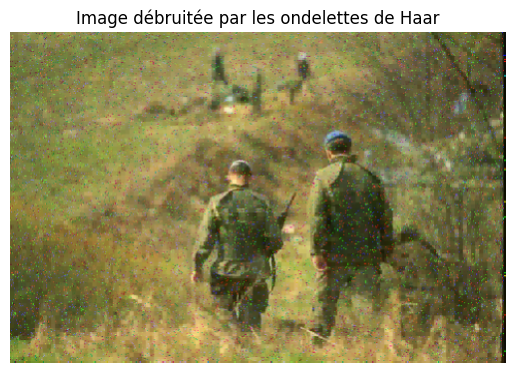

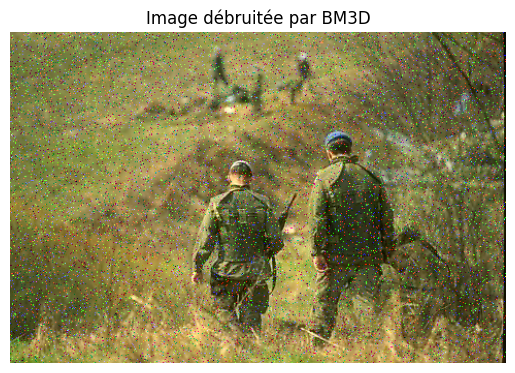

PSNR pour CGNet: 26.71
PSNR pour Filtre médian: 31.11
PSNR pour Ondelettes de Haar: 23.39
PSNR pour BM3D: 18.41


In [60]:
image = import_image("bsd500_military.jpg")
image_noised = noise_image(image, 's&p')
psnr_results = compare_denoising_methods(image, image_noised, 
                                         model_path='../_CGNet_BSD500/cgnet_denoising_optimized.pth', 
                                         median_func=median_denoise_color,
                                         wavelet_func=wavelet_denoise_color,
                                         bm3d_func=bm3d_denoise_color)